In [1]:
import scipy
import os
import numpy as np
import pandas as pd
from fooof.utils.io import load_fooofgroup as load_fooofgroup
from natsort import natsorted 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 14})
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import pickle
import imageio.v2 as imageio  # For saving GIFs
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical, plot_cortical2
from importlib import reload
import enigmatoolbox
reload(enigmatoolbox)
from enigmatoolbox.plotting import plot_cortical, plot_cortical2

import pickle
import seaborn as sns

In [2]:
with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\ICA_pruned_reduced\\plot_indeces_organization", 'rb') as file:
    new_indices = pickle.load(file)

############################################################################################
def reorganize_roi_gradient(original_data, new_indices=new_indices):
  '''
  A function that reorder the atlas parcels for plot purposes

  Arguments
  ---------
    original_data: a list.
      the original wrong ordered data, output of reorder_hemispheres function
    new_indices: a list.
      a list of the indeces in the new order
  Returns
  -------
    x: an array.
      the reordered data used for the cortical plot
  '''
  x = [original_data[i] for i in new_indices]
  return(np.array(x))
############################################################################################

############################################################################################
def reorder_hemispheres(original_data, first_left = True):
  '''
  A function that reorder the atlas parcels for plot purposes.

  Arguments
  ---------
    original_data: a list.
      the original wrong ordered data, output of reorder_hemispheres function
    first_left: a boolean.
      True if we want all left hemispheres parcels before right hemisphere ones,
      False otherwise
  Returns
  -------
    ordered_data: a list.
      the reordered data used for the cortical plot. This will become the input for
      the reorganize_roi_gradient function
  '''
  left_h = []
  right_h = []
  for idx, val in enumerate(original_data):
    idx +=1
    if idx%2==0:
      right_h.append(val)
    else:
      left_h.append(val)
  if first_left:
    ordered_data = np.concatenate((left_h, right_h))
  else:
    ordered_data = np.concatenate((right_h, left_h))
  return ordered_data.tolist()

def mat_struct_to_dict(mat_obj):
    """ Recursively convert MATLAB structs to Python dictionaries """
    if isinstance(mat_obj, scipy.io.matlab.mio5_params.mat_struct):
        return {field: mat_struct_to_dict(getattr(mat_obj, field)) for field in mat_obj._fieldnames}
    elif isinstance(mat_obj, list):
        return [mat_struct_to_dict(item) for item in mat_obj]
    else:
        return mat_obj


def load_aperiodic_from_mat_files(parent_directory, aperiodic_component = 'exponent'):
    """
    Loads and extracts FOOOF aperiodic component data from all `.mat` files in the specified parent directory.
    This function iterates over all `.mat` files in the given directory, processes them by 
    and stores the results in a dictionary.

    Parameters:
    -----------
    parent_directory : str
        Path to the directory containing `.mat` files.
    aperiodic_component = str
        choose wich aperioding component to extract between 'exponent' and 'offset'

    Returns:
    --------
    data_dict : dict
        A dictionary where:
            - Keys are the subject names (extracted from file names, removing '_Sprint' if present).
            - Values are the extracted FOOOF exponent data from the `.mat` file.

    Notes:
    ------
    - Only files ending with `.mat` are considered.
    - The function assumes that the key in the loaded `.mat` structure matches the filename (without `.mat`).
    - Requires `scipy.io.loadmat` to load `.mat` files and `natsort.natsorted` for natural sorting.
    """
    # Initialize an empty dictionary to store results
    data_dict = {}

    # Iterate over each file in the parent directory, sorted naturally
    for file_name in natsorted(os.listdir(parent_directory)):  
        if file_name.endswith('.mat'):  # Consider only .mat files
            file_path = os.path.join(parent_directory, file_name)
            key_name = file_name.replace('.mat', '')
            dict_key = key_name.replace('_Sprint', '')

            print(f"Loading subject {dict_key} and extracting FOOOF exponent data...")

            # Load .mat file
            mat_data = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)

            # Convert MATLAB structure to dictionary
            sprint_dict = mat_struct_to_dict(mat_data[key_name])

            # Extract and store exponent data
            data_dict[dict_key] = sprint_dict['Options']['SPRiNT']['topography'][aperiodic_component]

            # Free memory
            del sprint_dict  

    return data_dict


In [3]:
# Load the dictionary from the file
with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\Foof_res_correct\\Fooof_exponents.pkl", 'rb') as file:
    fooof_exponent_dict = pickle.load(file)

In [4]:
### LOADING ROIs NAME FROM EEGLAB DESIKAN ATLAS ###
labels = pd.read_excel('G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\Foof_res\\Desikan_regions.xlsx').values.tolist()
labels = [parcel_name[0].replace("'", "") for parcel_name in labels]
print(f'ROIs names: {labels}')

ROIs names: ['bankssts L', 'bankssts R', 'caudalanteriorcingulate L', 'caudalanteriorcingulate R', 'caudalmiddlefrontal L', 'caudalmiddlefrontal R', 'cuneus L', 'cuneus R', 'entorhinal L', 'entorhinal R', 'frontalpole L', 'frontalpole R', 'fusiform L', 'fusiform R', 'inferiorparietal L', 'inferiorparietal R', 'inferiortemporal L', 'inferiortemporal R', 'insula L', 'insula R', 'isthmuscingulate L', 'isthmuscingulate R', 'lateraloccipital L', 'lateraloccipital R', 'lateralorbitofrontal L', 'lateralorbitofrontal R', 'lingual L', 'lingual R', 'medialorbitofrontal L', 'medialorbitofrontal R', 'middletemporal L', 'middletemporal R', 'paracentral L', 'paracentral R', 'parahippocampal L', 'parahippocampal R', 'parsopercularis L', 'parsopercularis R', 'parsorbitalis L', 'parsorbitalis R', 'parstriangularis L', 'parstriangularis R', 'pericalcarine L', 'pericalcarine R', 'postcentral L', 'postcentral R', 'posteriorcingulate L', 'posteriorcingulate R', 'precentral L', 'precentral R', 'precuneus L'

#### CORRELATION FOOOF - THICKNESS

In [5]:
path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\Per_Immagini_paper\\"
cortical_thickness_data = scipy.io.loadmat(path + "Cor_thick_exp_pre_ictal.mat")['Thick_exp_corr']

In [6]:
cortical_thickness_data[0][1][0]

'Epi-time'

In [7]:
cortical_thicknedss_dict = {cortical_thickness_data[0][1][0]: {'rho': cortical_thickness_data[1][1], 'pval': cortical_thickness_data[2][1]},
                            cortical_thickness_data[0][2][0]: {'rho': cortical_thickness_data[1][2], 'pval': cortical_thickness_data[2][2]},
                            cortical_thickness_data[0][3][0]: {'rho': cortical_thickness_data[1][3], 'pval': cortical_thickness_data[2][3]},
                            cortical_thickness_data[0][4][0]: {'rho': cortical_thickness_data[1][4], 'pval': cortical_thickness_data[2][4]}
                            }

In [8]:
cortical_thicknedss_dict.keys()

dict_keys(['Epi-time', 'No-Epi-time', 'Epi-avg', 'No-Epi-ag'])

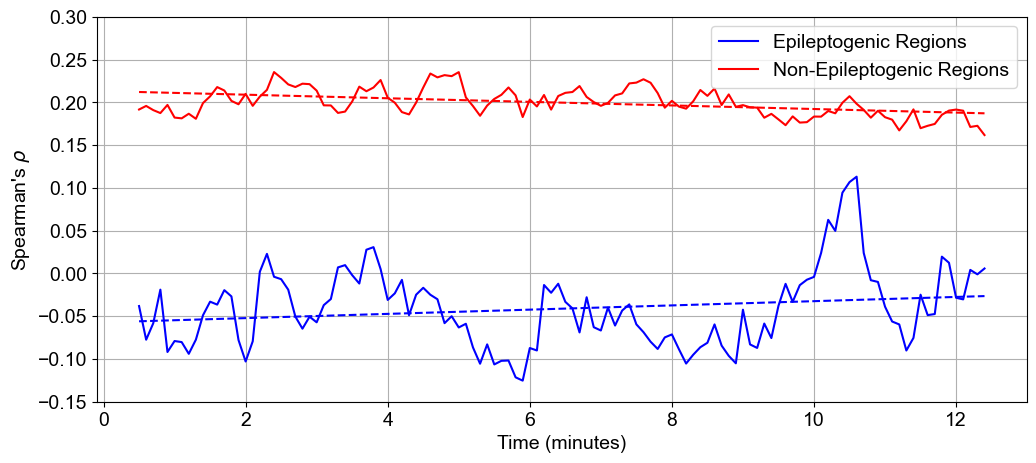

In [9]:
# Parameters
sampling_rate = 256  # Hz
signal_duration_sec = 13 * 60  # 780 seconds
window_length_sec = 60
step_size_sec = window_length_sec * (1 - 0.9)  # 6 seconds
num_segments = 121  # already known

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:120]

# Plot the two time series
plt.figure(figsize=(12, 5))

# Plot Selected Indices with std halo
x1 = window_center_times_min
plt.plot(x1, cortical_thicknedss_dict['Epi-time']['rho'], label="Epileptogenic Regions", color="blue")

coeffs_sel = np.polyfit(x1, cortical_thicknedss_dict['Epi-time']['rho'], 1)
plt.plot(x1, np.polyval(coeffs_sel, x1), linestyle='--', color='blue')

# Plot Non-Selected Indices with std halo
x2 = window_center_times_min
plt.plot(x2, cortical_thicknedss_dict['No-Epi-time']['rho'], label="Non-Epileptogenic Regions", color="red")

coeffs_non = np.polyfit(x2, cortical_thicknedss_dict['No-Epi-time']['rho'], 1)
plt.plot(x2, np.polyval(coeffs_non, x2), linestyle='--', color='red')

# Add labels and legend
plt.xlabel("Time (minutes)", fontsize = 14)
plt.ylabel(r"Spearman's $\rho$")
#plt.title("Pre-ictal")
plt.legend(loc = 'upper right')
plt.ylim(-0.15,0.3)
plt.grid(True)



# Show the plot
plt.show()
#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\fig 3\\correlation_thickness_fooof_preictal.png",dpi = 700)

### PLOT CERVELLINI EPI NON EPI

In [9]:
### LOADING EXCEL FILE WITH THE INDICES OD RELEVANT ROIs x SUBJECT ###
file_path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\relevant_rois_indices.xlsx" 
df_relevant_rois = pd.read_excel(file_path)
# Extract indices and IDs
list_indices =  list(zip(df_relevant_rois["ID"].tolist(), list(df_relevant_rois["INDICES_strict"].tolist())))


all_epi_rois = set()
for _, numbers_str in list_indices:
    nums = [int(n.strip()) for n in numbers_str.split(',')]
    all_epi_rois.update(nums)

unique_numbers = sorted(all_epi_rois)
print(unique_numbers)

[4, 8, 10, 11, 12, 14, 15, 16, 24, 25, 28, 29, 30, 32, 33, 34, 36, 37, 38, 39, 40, 41, 44, 45, 48, 51, 52, 53, 54, 55, 56, 58, 59, 60, 62, 63, 64]


In [10]:
mask = np.zeros(68, dtype=int)

# Set to 1 all positions with indexes in unique_numbers
for idx in unique_numbers:
    mask[idx] = 1

print(mask)

#scipy.io.savemat('G:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\PLOTS\immagini finali\\fig 3\\mask_per_plot.mat', {'mask': mask})


[0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1
 1 1 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0]


In [11]:
from importlib import reload
import enigmatoolbox
reload(enigmatoolbox)
from enigmatoolbox.plotting import plot_cortical, plot_cortical2

In [18]:
mask_2x2 = np.tile(reorganize_roi_gradient(reorder_hemispheres(mask)), (2, 2, 1))

In [32]:
interactive = False
# Apply transformations
reorganized_plot = parcel_to_surface(reorganize_roi_gradient(reorder_hemispheres(mask)), 'aparc_fsa5')

# Generate the cortical plot and save as an image
plot_cortical(array_name=reorganized_plot, surface_name="fsa5", size=(1000, 700),
              background=(1,1,1), transparent_bg=False, interactive=False, cmap='Oranges',
              color_bar=True, scale=(1,1), zoom=1.25, color_range=(0,1.2), screenshot=True, filename="G:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\PLOTS\immagini finali\\fig 3\\prova_Oranges.png")

'G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\fig 3\\prova_Oranges.png'

##### CERVELLINI 2 COLORI

In [ ]:
mask2 = np.zeros(68, dtype=int)
for i in range(len(mask2)):
  if i in unique_numbers:
    mask2[i] = 1
  else:
    mask2[i] = -1

print(mask2)

In [42]:
interactive = False
# Apply transformations
reorganized_plot = parcel_to_surface(reorganize_roi_gradient(reorder_hemispheres(mask2)), 'aparc_fsa5')

# Generate the cortical plot and save as an image
plot_cortical(array_name=reorganized_plot, surface_name="fsa5", size=(1000, 700),
              background=(1,1,1), transparent_bg=False, interactive=False, cmap='seismic',
              color_bar=True, scale=(1,1), zoom=1.25, color_range=(-1.3,1.3), screenshot=True, filename="G:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\PLOTS\immagini finali\\fig 3\\prova2_seismic.png")

'G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\fig 3\\prova2_seismic.png'

#### CERVELLINI 2 COLORI SFUMATURE PROGRESSIVE

In [11]:
list_indices =  list(zip(df_relevant_rois["ID"].tolist(), list(df_relevant_rois["INDICES_strict"].tolist())))

all_epi_rois = []
for _, numbers_str in list_indices:
    nums = [int(n.strip()) for n in numbers_str.split(',')]
    for i in nums:
        all_epi_rois.append(i)


In [12]:
all_nonepi_rois = []

for _, numbers_str in list_indices:
    nums = [int(n.strip()) for n in numbers_str.split(',')]
    # Find missing indices between 0 and 67
    full_range = set(range(68))
    missing = full_range - set(nums)
    all_nonepi_rois.extend(missing)  # Add the missing ones

In [23]:
unique, counts = np.unique(all_epi_rois, return_counts=True)

rois_count = dict(zip(unique, counts))

mask_epi = np.full(68, 0)  
for i in range(68):
    if i in rois_count.keys():
        mask_epi[i] = rois_count[i]

print(mask_epi)

[0 0 0 0 3 0 0 0 8 0 8 4 8 0 4 2 1 0 0 0 0 0 0 0 8 4 0 0 8 4 1 0 3 2 7 0 7
 4 7 4 7 4 0 0 4 2 0 0 4 0 0 2 8 4 8 4 3 0 4 2 1 0 4 2 8 0 0 0]


In [14]:
unique, counts = np.unique(all_nonepi_rois, return_counts=True)

rois_count = dict(zip(unique, counts))

mask_nonepi = np.full(68, 0)  
for i in range(68):
    if i in rois_count.keys():
        mask_nonepi[i] = rois_count[i]

print(mask_nonepi)
numcount_nonepi = max(mask_nonepi) - min(mask_nonepi) + 1

[29 29 29 29 26 29 29 29 21 29 21 25 21 29 25 27 28 29 29 29 29 29 29 29
 21 25 29 29 21 25 28 29 26 27 22 29 22 25 22 25 22 25 29 29 25 27 29 29
 25 29 29 27 21 25 21 25 26 29 25 27 28 29 25 27 21 29 29 29]


In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Step 1: Define the colors
colors = ['white'] + [plt.cm.Blues(i) for i in np.linspace(0.2, 1.0, 8)]

# Step 2: Create and register the updated colormap
custom_cmap = mcolors.ListedColormap(colors, name='blues_categorical')
#plt.register_cmap(name='blues_categorical', cmap=custom_cmap)

C:\Users\simon\AppData\Local\Temp\ipykernel_18228\2704203261.py:13: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(name='blues_categorical_v2', cmap=custom_cmap)


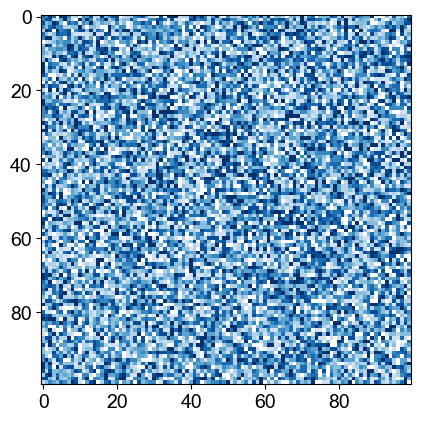

In [28]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Step 1: Define the colors
#colors = ['red'] + [plt.cm.Blues(i) for i in np.linspace(0.2, 1.0, 8)]
#colors = [plt.cm.Reds(i) for i in np.linspace(0.1, 1.0, 9)] + [plt.cm.Blues(i) for i in np.linspace(0.2, 1.0, 8)]

colors = ['white'] + [plt.cm.Blues(i) for i in np.linspace(0.2, 1.0, 8)]
#already created blues_categorical and reds_categorical for plotting nonepi rois (blues) and epi rois (reds)
# Step 2: Create and register the colormap
custom_cmap = mcolors.ListedColormap(colors, name='blues_categorical_v2')
plt.register_cmap(name='blues_categorical_v2', cmap=custom_cmap)

abc = np.random.randint(0, 9, size=(100, 100))
plt.imshow(abc, cmap='blues_categorical_v2')  # or pass cmap to plot_cortical


In [29]:
interactive = False
# Apply transformations
reorganized_plot = parcel_to_surface(reorganize_roi_gradient(reorder_hemispheres(mask_epi)), 'aparc_fsa5', fill= np.nan)

# Generate the cortical plot and save as an image
plot_cortical(array_name=reorganized_plot, surface_name="fsa5", size=(6000, 3200),
              background=(1,1,1), transparent_bg=False, interactive=False, cmap='blues_categorical_v2', nan_color=(1, 1, 1, 1),
              color_bar=True, scale=(1,1), zoom=1.25,  screenshot=True, filename="G:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\PLOTS\immagini finali\\fig 3\\cervellini_solo_epi.png")

'G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\fig 3\\cervellini_solo_epi.png'

##### CREATING FUCNTION TO GO FROM ENIGMALABEL ANNOT ORDER TO FREESURFER ANNOT ORDER #####

In [6]:
import nibabel as nib

# Path to your annotation file
annot_path_left = "G:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\Microstructure\\lh.aparc_mics.annot" # Change this to your actual file path
annot_path_right = "G:\Drive condivisi\AnalisiSegnaliEeg\HD EEG\Crisi_HDEEG\Microstructure\\rh.aparc_mics.annot" # Change this to your actual file path

# Read the annotation file
labels_microstruct, ctab_microstruct, names_microstruct_left = nib.freesurfer.read_annot(annot_path_left)
labels_microstruct, ctab_microstruct, names_microstruct_right = nib.freesurfer.read_annot(annot_path_right)


In [7]:
names_microstruct_left = [entry.decode('utf-8') + ' L' for entry in names_microstruct_left]
names_microstruct_right = [entry.decode('utf-8') + ' R' for entry in names_microstruct_right]


In [8]:
del names_microstruct_left[4], names_microstruct_left[0]
del names_microstruct_right[4], names_microstruct_right[0]

In [9]:
names_microstruct = names_microstruct_left + names_microstruct_right
print(names_microstruct)

['bankssts L', 'caudalanteriorcingulate L', 'caudalmiddlefrontal L', 'cuneus L', 'entorhinal L', 'fusiform L', 'inferiorparietal L', 'inferiortemporal L', 'isthmuscingulate L', 'lateraloccipital L', 'lateralorbitofrontal L', 'lingual L', 'medialorbitofrontal L', 'middletemporal L', 'parahippocampal L', 'paracentral L', 'parsopercularis L', 'parsorbitalis L', 'parstriangularis L', 'pericalcarine L', 'postcentral L', 'posteriorcingulate L', 'precentral L', 'precuneus L', 'rostralanteriorcingulate L', 'rostralmiddlefrontal L', 'superiorfrontal L', 'superiorparietal L', 'superiortemporal L', 'supramarginal L', 'frontalpole L', 'temporalpole L', 'transversetemporal L', 'insula L', 'bankssts R', 'caudalanteriorcingulate R', 'caudalmiddlefrontal R', 'cuneus R', 'entorhinal R', 'fusiform R', 'inferiorparietal R', 'inferiortemporal R', 'isthmuscingulate R', 'lateraloccipital R', 'lateralorbitofrontal R', 'lingual R', 'medialorbitofrontal R', 'middletemporal R', 'parahippocampal R', 'paracentral

In [10]:
sorted_names_microstruct = sorted(names_microstruct)
print(list(zip(sorted_names_microstruct, labels)))

[('bankssts L', 'bankssts L'), ('bankssts R', 'bankssts R'), ('caudalanteriorcingulate L', 'caudalanteriorcingulate L'), ('caudalanteriorcingulate R', 'caudalanteriorcingulate R'), ('caudalmiddlefrontal L', 'caudalmiddlefrontal L'), ('caudalmiddlefrontal R', 'caudalmiddlefrontal R'), ('cuneus L', 'cuneus L'), ('cuneus R', 'cuneus R'), ('entorhinal L', 'entorhinal L'), ('entorhinal R', 'entorhinal R'), ('frontalpole L', 'frontalpole L'), ('frontalpole R', 'frontalpole R'), ('fusiform L', 'fusiform L'), ('fusiform R', 'fusiform R'), ('inferiorparietal L', 'inferiorparietal L'), ('inferiorparietal R', 'inferiorparietal R'), ('inferiortemporal L', 'inferiortemporal L'), ('inferiortemporal R', 'inferiortemporal R'), ('insula L', 'insula L'), ('insula R', 'insula R'), ('isthmuscingulate L', 'isthmuscingulate L'), ('isthmuscingulate R', 'isthmuscingulate R'), ('lateraloccipital L', 'lateraloccipital L'), ('lateraloccipital R', 'lateraloccipital R'), ('lateralorbitofrontal L', 'lateralorbitofr

In [11]:
map_microstruct_to_brainstorm = [names_microstruct.index(label) for label in sorted_names_microstruct]
print(map_microstruct_to_brainstorm)

[0, 34, 1, 35, 2, 36, 3, 37, 4, 38, 30, 64, 5, 39, 6, 40, 7, 41, 33, 67, 8, 42, 9, 43, 10, 44, 11, 45, 12, 46, 13, 47, 15, 49, 14, 48, 16, 50, 17, 51, 18, 52, 19, 53, 20, 54, 21, 55, 22, 56, 23, 57, 24, 58, 25, 59, 26, 60, 27, 61, 28, 62, 29, 63, 31, 65, 32, 66]


#### RASTER PLOT WITH SPIN PERMUTATION ALL ROI ####

In [14]:
average_array_68 = np.mean(array_68, axis = 0)
reordered_array_brainstorm = average_array_68[map_microstruct_to_brainstorm]

average_fooof = np.mean(array_68x120, axis = 0)

NameError: name 'array_68' is not defined

In [23]:
corr_list, pval_list = [], []
for i in range(120):
  corr, pval = spearmanr(reorganize_roi_gradient(reorder_hemispheres(average_fooof[:,i])), reorganize_roi_gradient(reorder_hemispheres(reordered_array_brainstorm)))
  corr_list.append(corr)
  pval_list.append(pval)

In [24]:
from enigmatoolbox.permutation_testing import spin_test, shuf_test

p_spin =  []

for i in range(120):
  p = spin_test(reorganize_roi_gradient(reorder_hemispheres(average_fooof[:, i])), reorganize_roi_gradient(reorder_hemispheres(reordered_array_brainstorm)), surface_name='fsa5', parcellation_name='aparc',
                              type='spearman', n_rot=200)
  p_spin.append(p)

permutation 100 of 200


KeyboardInterrupt: 

In [13]:
path = "C:\\Users\\simon\\OneDrive\\Desktop\\list_indices_GM.xlsx"
# Load your Excel file
df = pd.read_excel(path)  # Replace with your filename

# Function to increment each index by 1
def increment_indices(cell):
    return ', '.join(str(int(x.strip()) + 1) for x in str(cell).split(','))

# Apply to the "INDICES" column
df['INDICES'] = df['INDICES'].apply(increment_indices)
df['INDICES_strict'] = df['INDICES_strict'].apply(increment_indices)

# Save the modified dataframe to a new Excel file
df.to_excel(path, index=False)